# Timepix3 Dataset Prototype

This notebook demonstrates the prototype LiberTEM dataset for raw Timepix3 data.

The data referenced were found at https://zenodo.org/record/3635923.

The decoding logic and file structure were inferred from (and heavily inspired by) the repository https://github.com/M4I-nanoscopy/tpx3HitParser and in particular the file https://github.com/M4I-nanoscopy/tpx3HitParser/blob/master/tpx3format/read.py.

In [1]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import libertem.api as lt
from libertem.udf.sum import SumUDF
from libertem.udf.sumsigudf import SumSigUDF

The dataset itself is imported from the local directory.

In [2]:
from timepix import Timepix3DataSet

In [3]:
data_idx = 0
data_root = pathlib.Path('~/Workspace/libertem_dev/data/'
                         'timepix/experimental_200kv/').expanduser()

data_paths = [data_root / 'edge/edge1_000001.tpx3',
              data_root / 'espb/espbm_000004.tpx3',
              data_root / 'flat_field/ff_000000.tpx3',
              data_root / 'foil_holes/foil_000001.tpx3']
data_path = data_paths[data_idx]

In [4]:
ctx = lt.Context.make_with('inline')

The data used here are all TEM data so don't have obvious frames to analyse. Instead I arbitrarily choose a `nav_shape` which will split the file into (approximately) equal-time chunks to fit the total number of 'frames'.

The dataset can generate dense or `pydata.sparse.COO` tiles. As the LiberTEM on this branch can't currently handle sparse frames I use `as_dense=True`. The hits => sparse conversion process currently passes via a densification step anyway as this is currently the most efficient method for these data.

In [5]:
ds = Timepix3DataSet(data_path, (10, 10), as_dense=True)
ds = ds.initialize(ctx.executor)
ds.set_num_cores(4)

The dataset supports ROIs (but not sync_offset), so we add a random ROI to demonstrate.

In [6]:
roi = np.random.randint(0, 2, size=ds.meta.shape.nav, dtype=bool)
udfs = (SumUDF(), SumSigUDF())
res = ctx.run_udf(dataset=ds, udf=udfs, progress=True, roi=roi)

100%|███████████████████████████████████| 4/4 [00:14<00:00,  3.69s/it]


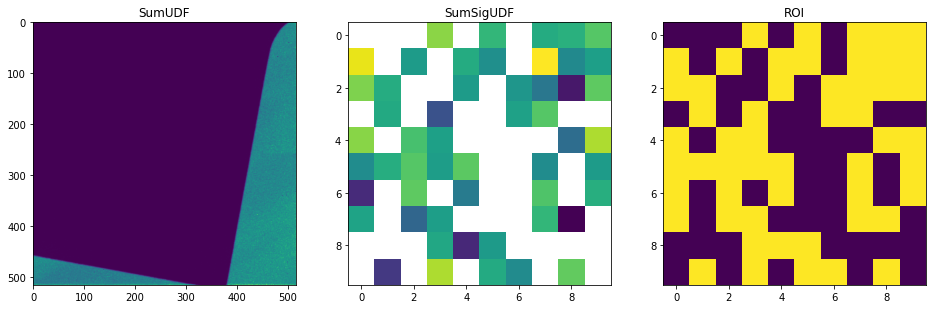

In [9]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 8))
sig_res = res[0]['intensity'].data
# Seems to be a hot pixel (marker pixel ??)
sig_res[208, 317] = 0
ax0.imshow(sig_res)
ax0.set_title(udfs[0].__class__.__name__)
ax1.imshow(res[1]['intensity'].data)
ax1.set_title(udfs[1].__class__.__name__)
if roi is not None:
    ax2.imshow(roi)
ax2.set_title('ROI')
plt.show()

## Limitations

The prototype has a lot of limitations:

- The aforementioned hits => dense => sparse processing chain. Improving this will require some kind of low-level implementation for de-duplicating hits and summing their (corrected) ToT values.
- Not tested in detail for correctness when mapping timestamps to frames.
- Support for timer rollover is present but flaky at best.
- Mapping timestamps to frames is arbitrary because we have no external trigger/markers for the frames. Right now by default the (approximate) full span of time in the file is split evenly between the arbitrary number of frames we choose.
- No Time-Over-Threshold correction implementation. In the upstream library there is a `(1024, 256, 256, number_of_chips)` lookup table which is used to correct each-and-every decoded event. Inspecting the LUT it's uint16 therefore ~512 MB of data to share between all the workers somehow. I would imagine it's also sensor specific!
- No Time-Of-Arrival phase correction. I think this is related to certain columns / rows of each chip being slightly faster/slower than other and thefore requiring a constant offset. (Might also be chip/camera-specifc and dependent on the low-level configuration of the acquisition).